Introduction and Objective
This lab implements an automated pipeline using image segmentation and morphological operations to:

- Detect the number of nuts and bolts in each batch image
- Compare counts against the target N = 25
- Provide recommendations to add or remove parts as needed

**Outputs per image:**
1. Number of nuts detected
2. Number of bolts detected
3. Status message:
   - "All good" if both counts equal N
   - "Add X nuts/bolts" if count < N
   - "Remove Y nuts/bolts" if count > N



Image: Nuts+Bolts-1.jpg
Detected nuts: 25
Detected bolts: 25
All good


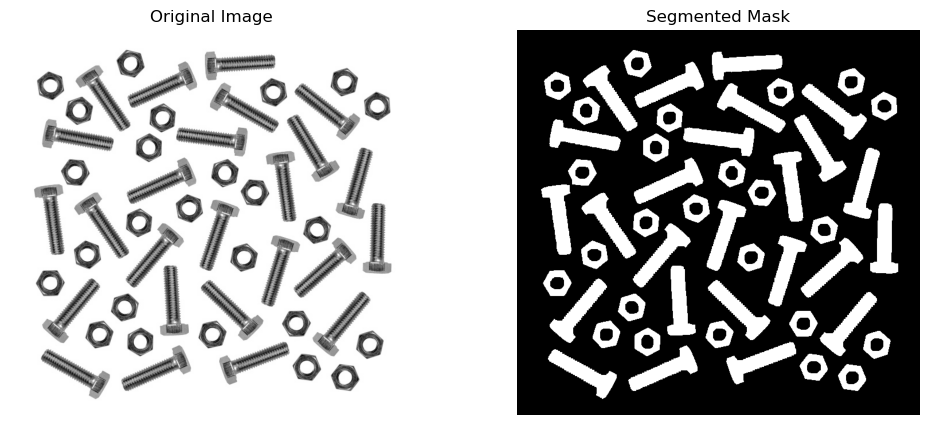


Image: Nuts+Bolts-2.jpg
Detected nuts: 22
Detected bolts: 23
Add 3 nuts, Add 2 bolts


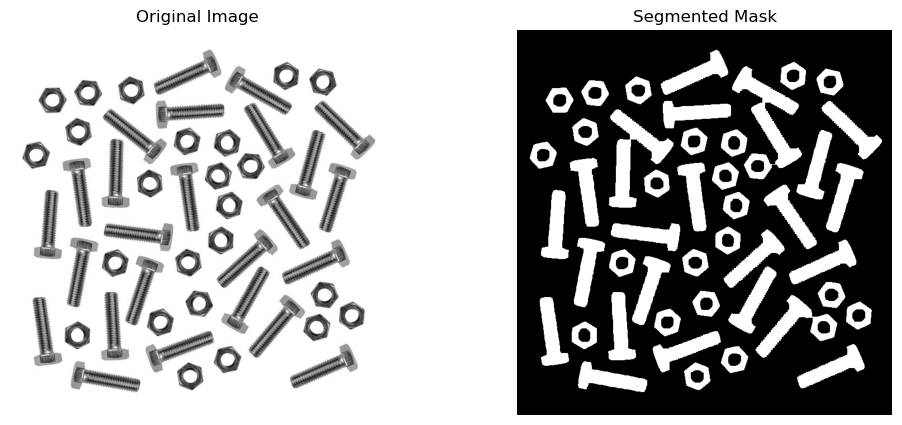


Image: Nuts+Bolts-3.jpg
Detected nuts: 25
Detected bolts: 26
Remove 1 bolts


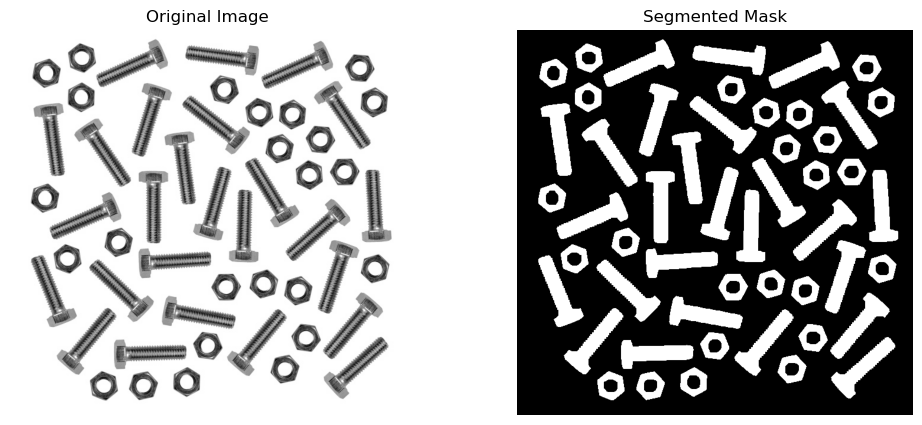

: 

In [ ]:

# 0. Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

# %%
# 1. Set hyperparameters and configuration
# Number of nuts and bolts expected per batch
N = 25

# Thresholding method: 'manual' uses THRESHOLD_VALUE, 'otsu' computes automatically
THRESHOLD_METHOD = 'otsu'  # options: 'manual', 'otsu'
THRESHOLD_VALUE = 127      # used only when THRESHOLD_METHOD == 'manual'

# Morphological processing parameters
MORPH_KERNEL_SIZE = (5, 5)
MORPH_ITERATIONS = 2

# Area thresholds for classification (in pixels)
MIN_NUT_AREA = 500
MAX_NUT_AREA = 1500
MIN_BOLT_AREA = 1500

# Input images list
IMAGE_FILES = [
    'Nuts+Bolts-1.jpg',
    'Nuts+Bolts-2.jpg',
    'Nuts+Bolts-3.jpg'
]

# %%
# 2. Define the image processing function
def process_image(img_path):
    # Read and convert to grayscale
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply thresholding
    if THRESHOLD_METHOD == 'otsu':
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        _, binary = cv2.threshold(gray, THRESHOLD_VALUE, 255, cv2.THRESH_BINARY_INV)

    # Morphological operations to clean up the mask
    kernel = np.ones(MORPH_KERNEL_SIZE, np.uint8)
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=MORPH_ITERATIONS)

    # Connected components analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned)
    nuts = 0
    bolts = 0

    # Iterate through components (skip background label = 0)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if MIN_NUT_AREA <= area <= MAX_NUT_AREA:
            nuts += 1
        elif area >= MIN_BOLT_AREA:
            bolts += 1

    return img, cleaned, nuts, bolts

# %%
# 3. Process all images and report results
for img_file in IMAGE_FILES:
    orig, mask, nuts_count, bolts_count = process_image(img_file)
    print(f"\nImage: {img_file}")
    print(f"Detected nuts: {nuts_count}")
    print(f"Detected bolts: {bolts_count}")

    # Determine action messages
    actions = []
    if nuts_count < N:
        actions.append(f"Add {N - nuts_count} nuts")
    elif nuts_count > N:
        actions.append(f"Remove {nuts_count - N} nuts")
    if bolts_count < N:
        actions.append(f"Add {N - bolts_count} bolts")
    elif bolts_count > N:
        actions.append(f"Remove {bolts_count - N} bolts")

    if not actions:
        print("All good")
    else:
        print(", ".join(actions))

    # %%
    # 4. Visualize original and segmented results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Segmented Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()
